<a href="https://colab.research.google.com/github/rogeriothur/data_science_studies/blob/main/Predi%C3%A7%C3%A3o%20de%20Clientes%20(CHURN)%20do%20banco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Previsão (churn) de clientes do banco**

## Contextualização do problema
Neste problema, o objetivo é prever os clientes que irão sair do banco.


> OBJETIVO: Criar um modelo que classifique os clientes que vão sair do banco

Espera-se que o modelo seja capaz de minimizar as perdas de clientes



## Importando bibliotecas
## Obtendo os dados

In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import warnings
warnings.filterwarnings('ignore')

In [20]:
df = pd.read_csv('bank_customers.csv')

## Análise de dados

**Dicionário das variáveis**

* `RowNumber` - número do registro (linha)
* `CustomerId` - identificação do cliente
* `Surname` - sobrenome do cliente
* `CreditScore` - pontuação de crédito
* `Geography` - localização do cliente (país)
* `Gender` - gênero do cliente
* `Age` - idade do cliente
* `Tenure` - tempo em que é cliente (anos)
* `Balance` - saldo do cliente
* `NumOfProducts` - número de produtos que o cliente comprou por meio do banco
* `HasCrCard` - cliente possui cartão de crédito? (boolean)
* `IsActiveMember` - é cliente ativo? (boolean)
* `EstimatedSalary` - salário estimado
* `Exited` - saiu do banco? (boolean)

**Informações que o dataset forneceu**

* `RowNumber` - não tem efeito na saída do cliente
* `CustomerId` - não tem efeito na saída do cliente
* `Surname` - não tem efeito na saída do cliente
* `CreditScore` - tem efeito na saída do cliente, uma vez que um cliente com uma pontuação de crédito mais alta tem menos probabilidade de deixar o banco
* `Geography` - pode afetar sua decisão de deixar o banco
* `Gender` - interessante explorar se desempenha um papel na saída do cliente
* `Age` - clientes mais velhos têm menos probabilidade de sair do banco
* `Tenure` - normalmente os clientes com mais tempo de casa são mais leais e menos propenso a deixar o banco
* `Balance` - clientes com saldos mais altos têm menos probabilidade de deixar o banco
* `HasCrCard` - clientes com cartão de crédito têm menos probabilidade de deixar o banco
* `IsActiveMember` - clientes ativos tem menos probabilidade de deixar o banco 
* `EstimatedSalary` - similar ao saldo (balance)

### Conhecendo os dados

In [21]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Quantos atributos (variáveis) e quantas entradas o nosso conjunto de dados possui?
### Quais os tipos das variáveis?
### Qual a porcentagem de valores ausentes no *dataset*?

Vamos prosseguir e identificar a quantidade de entradas que nosso conjunto de dados possui e ver os tipos de cada coluna

In [22]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [23]:
def eda(df):
    """
    Gera uma dataframe com informações relevantes sobre o mesmo.
    Generates a dataframe with relevant information about it
    
    :param df: pd.DataFrame para ser realizada a exploração
    :param df: pd.DataFrameto be explored
    """
    
    explorar = pd.DataFrame({
        'tipo' : df.dtypes,
        'quantidade_nula' : df.isnull().sum()
    })
    
    explorar['porcentagem_nula'] = np.round((explorar.quantidade_nula / df.shape[0]) * 100, 4)
    
    display(f'Entradas: {df.shape[0]}')
    display(f'Variáveis: {df.shape[1]}')
    
    return explorar.sort_values(by='quantidade_nula', ascending=False)

In [24]:
eda(df)

'Entradas: 10000'

'Variáveis: 14'

,tipo,quantidade_nula,porcentagem_nula
RowNumber,int64,0,0.0
CustomerId,int64,0,0.0
Surname,object,0,0.0
CreditScore,int64,0,0.0
Geography,object,0,0.0
Gender,object,0,0.0
Age,int64,0,0.0
Tenure,int64,0,0.0
Balance,float64,0,0.0
NumOfProducts,int64,0,0.0


#### Conclusões:


*   O DataFrame possui 14 variáveis e 10k de entradas
*   Existem variáveis do tipo int, object e float
*   Não tem valores ausentes



## Qual o tipo de distribuição das variáveis?
Para identificar a distribuição das variáveis, irei plotar o histograma

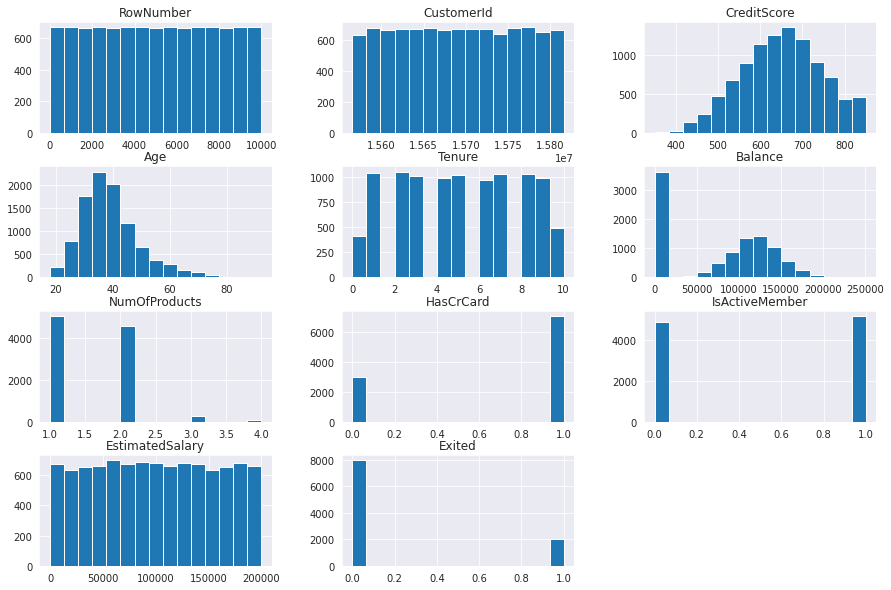

In [25]:
df.hist(bins=15,figsize=(15,10))
plt.show()

### Conclusões:


*   CreditScore está em uma distribuição próxima a uma normal
*   Idade (distribuição assimétrica positiva, média > mediana > moda)



### Ações:


*   Excluir colunas que não tem impacto no modelo
*   Alterar tipo das variáveis




In [26]:
df.drop(columns=['RowNumber', 'Surname', 'CustomerId'], inplace=True)

## Verificar *outliers* nos dados

In [27]:
def amplitude_interquartil(df, coluna):
    
    q1 = coluna.quantile(.25)
    q3 = coluna.quantile(.75)
    iiq = q3 - q1
    
    limite_inferior = q1 - (1.5 * iiq)
    limite_superior = q3 + (1.5 * iiq)
    
    filtro = (coluna >= limite_inferior) & (coluna <= limite_superior)
    return df[filtro]

### Variável CreditScore

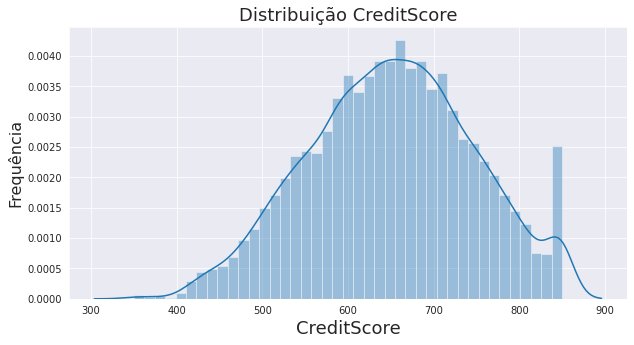

In [28]:
plt.figure(figsize=(10,5))
plt.title('Distribuição CreditScore', fontsize=18)
plt.xlabel('',fontsize=18)
plt.ylabel('Frequência',fontsize=16)

sns.distplot(df.CreditScore)
plt.show()

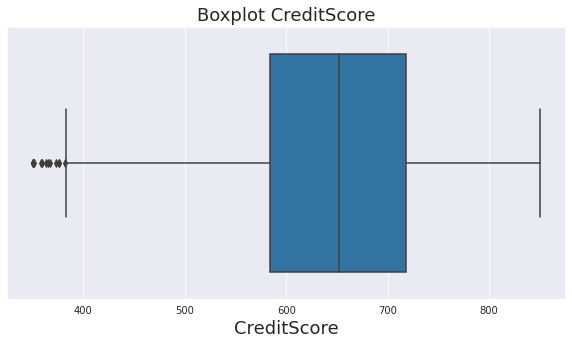

In [29]:
plt.figure(figsize=(10,5))
plt.title('Boxplot CreditScore', fontsize=18)
plt.xlabel('',fontsize=18)

sns.boxplot(x='CreditScore', data=df)

plt.show()

In [30]:
#df = amplitude_interquartil(df, df.CreditScore.sort_values())

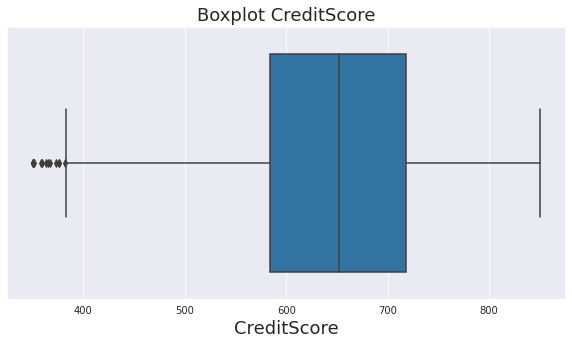

In [31]:
plt.figure(figsize=(10,5))
plt.title('Boxplot CreditScore', fontsize=18)
plt.xlabel('',fontsize=18)

sns.boxplot(x='CreditScore', data=df)

plt.show()

### Variável Age


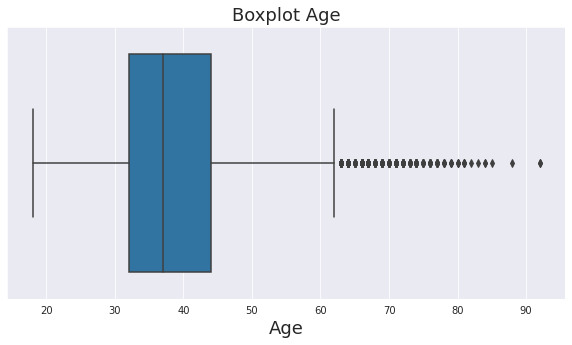

In [32]:
plt.figure(figsize=(10,5))
plt.title('Boxplot Age', fontsize=18)
plt.xlabel('',fontsize=18)

sns.boxplot(x='Age', data=df)

plt.show()

In [33]:
#df = amplitude_interquartil(df, df.Age.sort_values())

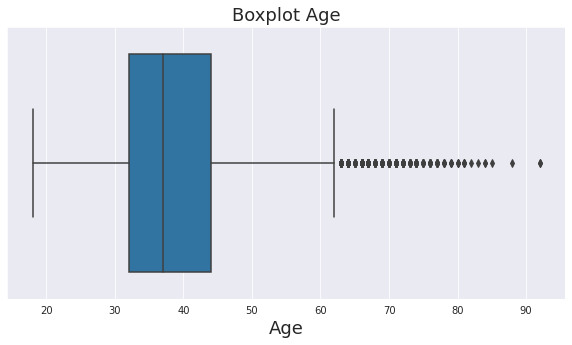

In [34]:
plt.figure(figsize=(10,5))
plt.title('Boxplot Age', fontsize=18)
plt.xlabel('',fontsize=18)

sns.boxplot(x='Age', data=df)

plt.show()

## Visualizações

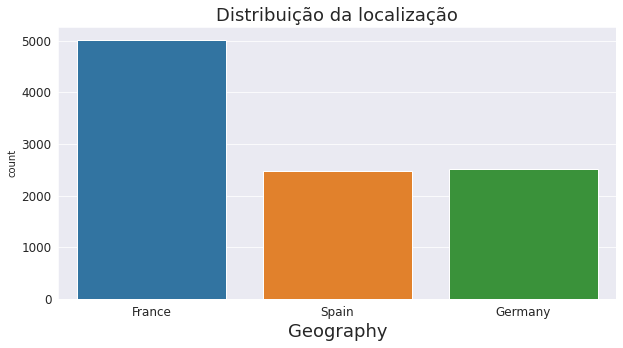

In [35]:
plt.figure(figsize=(10,5))
plt.title('Distribuição da localização', fontsize=18)
plt.xlabel('',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.countplot(data=df, x='Geography')

plt.show()

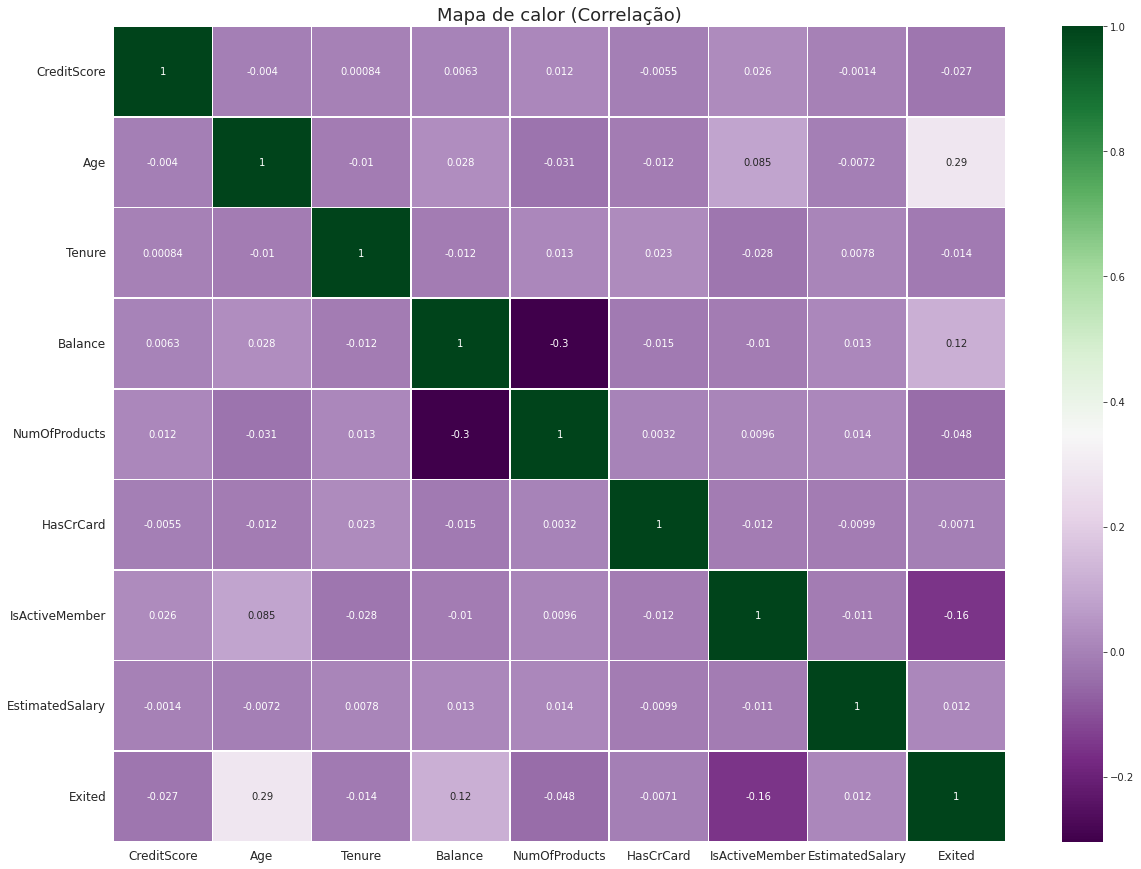

In [36]:
correlations = df.corr()

plt.figure(figsize=(20,15))
plt.title("Mapa de calor (Correlação)", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.heatmap(correlations, annot=True, cmap="PRGn", linewidths=.5)

plt.show()

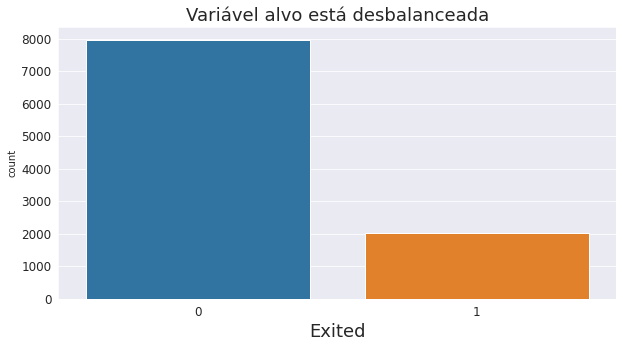

In [37]:
plt.figure(figsize=(10,5))
plt.title('Variável alvo está desbalanceada', fontsize=18)
plt.xlabel('',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.countplot(data=df, x='Exited')

plt.show()

- Com classes desbalanceada o modelo irá ficar enviesado, pois irá aprender muito sobre um classe da nossa variável alvo e pouco de outra classe
- Mas neste contexto é natural que essa variável esteja desbalanceada, pois é mais comum os clientes permaneçam no banco do que deixarem o banco (*comum para o contexto*)

## Transformando colunas categóricas em numéricas
- pois temos algumas colunas categóricas, precisamos transformar isso para fornecer ao nosso modelo somente dados do tipo númerico
- Com o método *get_dummies* cada string única foi transformada em um coluna, e nesta coluna caso o registro existir recebe 1 e 0 nas outras colunas

In [38]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [39]:
df = pd.get_dummies(df)

In [40]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [41]:
df.dtypes

CreditScore            int64
Age                    int64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
Geography_France       uint8
Geography_Germany      uint8
Geography_Spain        uint8
Gender_Female          uint8
Gender_Male            uint8
dtype: object

## XGBoost (classes desbalanceadas)
- Modelo com classes desbalancedas
- A escolha do XGBoost para a construção do modelo, deu-se após testes de outros algoritmos como (Regressão logistíca, DecisionTree). No qual, o XGBoost obteve uma melhor performance nos 3 cenários descritos abaixo
- Apesar que não foi feito um *tunning* de parâmetros, o modelo obteve uma boa perfomance


In [97]:
# Criando instância
clf = xgboost.XGBRFClassifier(max_depth=10, random_state=22)

In [98]:
# Separando o X e y (variável alvo)
X = df.drop(columns=['Exited'])
y = df.Exited

In [99]:
# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                     y,
                                                     random_state=22,
                                                     stratify=y,
                                                     test_size=0.3,
                                                     train_size=0.7) 

### Treinar o modelo

In [100]:
clf.fit(X_train, y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=10, min_child_weight=1, missing=None,
                n_estimators=100, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=22, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

#### Verificando a performance
- Acurácia (não é um bom medidor visto que as classes são balanceadas, % de acerto do modelo)

In [101]:
y_pred = clf.predict(X_test)

In [102]:
print("Acurácia: %.2f%%" % (accuracy_score(y_test, y_pred) * 100))

Acurácia: 85.60%


### Relatório de Classificação
- Importante observar as *Métricas* Precision e Recall

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      2389
           1       0.76      0.43      0.55       611

    accuracy                           0.86      3000
   macro avg       0.82      0.70      0.73      3000
weighted avg       0.85      0.86      0.84      3000



#### Matriz de confusão

In [104]:
print(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito     0    1   All
Real                    
0        2308   81  2389
1         351  260   611
All      2659  341  3000


### Algumas conclusões
- Podemos observa que na métrica de recall e também no f1-score. O modelo errou muito na classe 1 (minoritária) em relação a classe 0 (marjoritária)
- E na matriz de confusão também percebemos isso, o modelo acertou bastante para a classe marjoritária

## Vamos aplicar a NearMiss
- NearMiss é um método de *Undersampling*
- *Undersampling* iguala as quantidades de amostras entre as classes

## Aplicando o NearMiss nos dados para igualar a quantidade de amostras das classes

In [105]:
# Separando o X e y (variável alvo)
X = df.drop(columns=['Exited'])
y = df.Exited

In [106]:
# Criando instância
nr = NearMiss()

In [107]:
# Aplicando o NearMiss
X, y = nr.fit_sample(X, y)

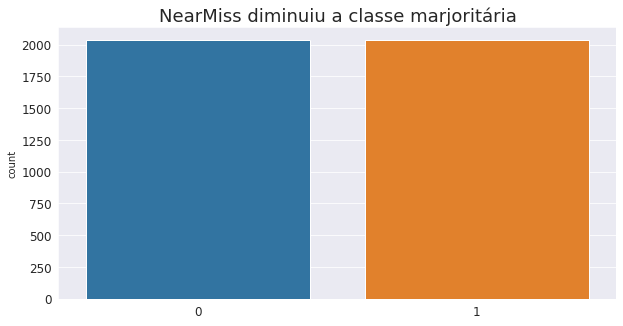

In [108]:
plt.figure(figsize=(10,5))
plt.title('NearMiss diminuiu a classe marjoritária', fontsize=18)
plt.xlabel('',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.countplot(x=y)

plt.show()

## Criar novamente o modelo com XGBoost

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                     y,
                                                     random_state=22,
                                                     stratify=y,
                                                     test_size=0.3,
                                                     train_size=0.7)

In [110]:
clf = xgboost.XGBRFClassifier(max_depth=10, random_state=22)
clf.fit(X_train, y_train) # Treina o modelo
y_pred = clf.predict(X_test) # faz a classificação

In [111]:
print("Acurácia: %.2f%%" % (accuracy_score(y_test, y_pred) * 100)) # Verificando acurácia

Acurácia: 91.01%


### Acurácia aumentou
- Porém a base de dados foi reduzida drasticamente após aplicar o *UnderSampling*
- O ponto positivo é que o modelo soube lidar melhor com as duas classes

In [112]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       611
           1       0.93      0.88      0.91       612

    accuracy                           0.91      1223
   macro avg       0.91      0.91      0.91      1223
weighted avg       0.91      0.91      0.91      1223



### Matriz de confusão

In [113]:
print(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito    0    1   All
Real                   
0        572   39   611
1         71  541   612
All      643  580  1223


## Vamos aplicar a SMOTE
- SMOTE é um método de *OverSamplig*
- O SMOTE irá gerar dados sintéticos da classe minotirária

In [114]:
# Separando o X e y (variável alvo)
X = df.drop(columns='Exited')
y = df.Exited

#### Criando objeto SMOTE
- o parâmetro definido é o tamanho em porcentagem que a classe minoritária terá em relação a marjoritária

In [115]:
# Criando instância
smt = SMOTE(sampling_strategy=0.7)

#### Aplicando o SMOTE nos dados

In [116]:
# Aplicando o SMOTE
X, y = smt.fit_sample(X,y)

#### Visualizando a distribuição pós SMOTE

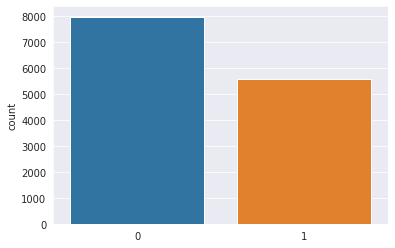

In [117]:
sns.countplot(x=y)

#### Separando em treino e teste

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                     y,
                                                     random_state=22,
                                                     stratify=y,
                                                     test_size=0.3,
                                                     train_size=0.7)

In [119]:
clf = xgboost.XGBRFClassifier(max_depth=10, random_state=22)
clf.fit(X_train, y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=10, min_child_weight=1, missing=None,
                n_estimators=100, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=22, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

In [120]:
y_pred = clf.predict(X_test) # faz a classificação

In [121]:
print("Acurácia: %.2f%%" % (accuracy_score(y_test, y_pred) * 100)) # Verificando acurácia

Acurácia: 88.36%


In [122]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2389
           1       0.91      0.80      0.85      1673

    accuracy                           0.88      4062
   macro avg       0.89      0.87      0.88      4062
weighted avg       0.89      0.88      0.88      4062



In [123]:
print(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito     0     1   All
Real                     
0        2249   140  2389
1         333  1340  1673
All      2582  1480  4062


# Conclusão
- O primeiro modelo apesar de que obteve uma boa acurária, aprendeu bastante sobre a classe marjoritária e muito pouco sobre a classe minoritária
- O segundo modelo o maior problema foi a grande redução da base de dados
- O terceiro modelo apesar de ter tido fornecido dados sintéticos, acredito que é o modelo mais viável (dependendo da métrica)

## Métricas


## Precision
- dos casos que eu previ como positivos (para uma classe) quantos realmente são?
- orçamento *interessa*

## Recall
- dos que eram realmente positivos (para uma classe) quantos eu detectei?
- taxa de detecção
- orçamento não pesa

## F1 Score
- média harmônica entre os dois acima